# Formatting Gemini Data
## Ver 2
Formatting Gemini data for input into d3 dashboard

In [1]:
import pandas as pd
from tqdm import tqdm

Read in gemini data

In [2]:
%%time
with open("./gemini_pull_2019_01_16_18_07_06.txt", "r") as file:
    gemini = file.read()

CPU times: user 3.66 ms, sys: 5.25 ms, total: 8.91 ms
Wall time: 155 ms


Separate messages

In [3]:
%%time
gemini_list = gemini.replace("}{", "}\n{").split("\n")

CPU times: user 10.2 ms, sys: 4.22 ms, total: 14.4 ms
Wall time: 14.6 ms


In [4]:
len(gemini_list)

10844

The first message is larger, gives remaining interest for all price points at the time of socket open

In [5]:
[len(i) for i in gemini_list[:10]]

[386154, 219, 222, 220, 226, 224, 222, 220, 222, 219]

In [6]:
first_msg = gemini_list[0]

In [7]:
first_msg[:400]

'{"type":"update","eventId":5368619062,"socket_sequence":0,"events":[{"type":"change","reason":"initial","price":"0.01","delta":"191642.102","remaining":"191642.102","side":"bid"},{"type":"change","reason":"initial","price":"0.02","delta":"22959.5","remaining":"22959.5","side":"bid"},{"type":"change","reason":"initial","price":"0.03","delta":"33","remaining":"33","side":"bid"},{"type":"change","rea'

In [8]:
first_message_df = pd.read_json(gemini_list[0])

In [9]:
first_message_df.head()

,eventId,events,socket_sequence,type
0,5368619062,"{'remaining': '191642.102', 'price': '0.01', '...",0,update
1,5368619062,"{'remaining': '22959.5', 'price': '0.02', 'del...",0,update
2,5368619062,"{'remaining': '33', 'price': '0.03', 'delta': ...",0,update
3,5368619062,"{'remaining': '0.00055', 'price': '0.04', 'del...",0,update
4,5368619062,"{'remaining': '3693', 'price': '0.05', 'delta'...",0,update


In [10]:
event_keys = first_message_df["events"].iloc[0].keys()

In [11]:
for i in event_keys:
    first_message_df[i] = first_message_df["events"].map(lambda x: x[i])

In [12]:
first_message_df.head()

,eventId,events,socket_sequence,type,remaining,price,delta,reason,side
0,5368619062,"{'remaining': '191642.102', 'price': '0.01', '...",0,change,191642.102,0.01,191642.102,initial,bid
1,5368619062,"{'remaining': '22959.5', 'price': '0.02', 'del...",0,change,22959.5,0.02,22959.5,initial,bid
2,5368619062,"{'remaining': '33', 'price': '0.03', 'delta': ...",0,change,33,0.03,33,initial,bid
3,5368619062,"{'remaining': '0.00055', 'price': '0.04', 'del...",0,change,0.00055,0.04,0.00055,initial,bid
4,5368619062,"{'remaining': '3693', 'price': '0.05', 'delta'...",0,change,3693,0.05,3693,initial,bid


each price shows up once:

In [13]:
first_message_df.price.value_counts().head()

3452.70     1
7817.39     1
3800.00     1
13824.00    1
3329.29     1
Name: price, dtype: int64

delta always equals remaining:

In [14]:
len(first_message_df[first_message_df.remaining != first_message_df.delta])

0

In [15]:
initial_interest = first_message_df[["side", "price", "remaining"]].drop_duplicates()

In [16]:
len(initial_interest)

3585

In [17]:
gemini_list[1]

'{"type":"update","eventId":5368619071,"timestamp":1547662175,"timestampms":1547662175932,"socket_sequence":1,"events":[{"type":"change","side":"bid","price":"3614.45","remaining":"0","delta":"-0.04","reason":"cancel"}]}'

In [18]:
%%time
update_str = ", ".join(gemini_list[1:])

CPU times: user 0 ns, sys: 2.71 ms, total: 2.71 ms
Wall time: 2.73 ms


In [19]:
%%time
all_updates_df = pd.read_json("[{}]".format(update_str))

CPU times: user 125 ms, sys: 20.8 ms, total: 146 ms
Wall time: 148 ms


In [20]:
%%time
all_updates_df["num_events"] = all_updates_df.events.map(len)

CPU times: user 1.84 ms, sys: 4.21 ms, total: 6.06 ms
Wall time: 6.25 ms


In [22]:
for i in tqdm(event_keys):
    all_updates_df[i] = all_updates_df["events"].map(lambda x: x[-1][i] if i in x[-1].keys() else "missing")

100%|██████████| 6/6 [00:00<00:00, 62.23it/s]


In [23]:
all_updates_df["price_double"] = all_updates_df.price.astype("double").round(2)

In [24]:
all_updates_df.num_events.value_counts()

1    10645
2      198
Name: num_events, dtype: int64

In [25]:
trades = all_updates_df[all_updates_df.num_events == 2]

In [26]:
trades.iloc[:2]

,eventId,events,socket_sequence,timestamp,timestampms,type,num_events,remaining,price,delta,reason,side,price_double
37,5368619504,"[{'price': '3620.42', 'amount': '0.45', 'tid':...",38,2019-01-16 18:09:37,2019-01-16 18:09:37.570,change,2,0.518,3620.42,-0.45,trade,bid,3620.42
107,5368620111,"[{'price': '3620.50', 'amount': '0.1', 'tid': ...",108,2019-01-16 18:09:40,2019-01-16 18:09:40.469,change,2,0.611,3620.50,-0.1,trade,bid,3620.50


In [27]:
trades.sort_values("price_double").price_double.round(3).iloc[0]

3612.6399999999999

In [28]:
all_updates_df.price.map(len).value_counts()

7    10843
Name: price, dtype: int64

In [29]:
all_updates_df.price.nunique()

1775

In [30]:
all_updates_rest_df = pd.concat([
        all_updates_df[["price", "side", "timestampms", "remaining", "type", "socket_sequence"]],
        initial_interest]).reset_index().drop(columns = ["index"])

In [33]:
all_updates_df.shape

(10843, 13)

In [34]:
initial_interest.shape

(3585, 3)

In [35]:
all_updates_rest_df.shape

(14428, 6)

In [36]:
all_updates_rest_df["fixed_timestampms"] = all_updates_rest_df.timestampms.map(lambda x: x if pd.notnull(x) else all_updates_rest_df.timestampms.min())

In [37]:
all_updates_rest_df["fixed_type"] = all_updates_rest_df["type"].map(lambda x: x if pd.notnull(x) else "change")

In [40]:
all_updates_rest_df["fixed_socket_sequence"] = all_updates_rest_df["socket_sequence"].map(lambda x: x if pd.notnull(x) else 0)

In case of multiple events at the same price/side/type and time, take the latest event

In [63]:
num_events = all_updates_rest_df.groupby(["price", "side", "fixed_type", "fixed_timestampms"], as_index = False)["fixed_socket_sequence"].count()

In [64]:
num_events.sort_values("fixed_socket_sequence", ascending = False).head()

,price,side,fixed_type,fixed_timestampms,fixed_socket_sequence
10128,3621.01,bid,change,2019-01-16 18:12:24.796,2
5581,3614.71,bid,change,2019-01-16 18:31:12.523,2
3168,3608.51,bid,change,2019-01-16 18:13:19.965,2
3172,3608.51,bid,change,2019-01-16 18:13:20.366,2
3173,3608.51,bid,change,2019-01-16 18:13:20.466,2


In [65]:
max_socket_sequence = all_updates_rest_df.groupby(
    ["price", "side", "fixed_type", "fixed_timestampms"], as_index = False)["fixed_socket_sequence"].max()

In [67]:
all_updates_rest_sing_df = all_updates_rest_df.merge(
    right = max_socket_sequence,
    on = ["price", "side", "fixed_type", "fixed_timestampms", "fixed_socket_sequence"],
    how = "inner")

In [68]:
all_updates_rest_df.shape

(14428, 10)

In [69]:
all_updates_rest_sing_df.shape

(14399, 10)

In [70]:
all_updates_rest_sing_df["price_padded"] = all_updates_rest_sing_df.price.str.pad(7, "left", "0")

In [71]:
trades_range = [
    trades.price.str.pad(7, "left", "0").min(),
    trades.price.str.pad(7, "left", "0").max()]

In [72]:
all_updates_rest_sing_df["fixed_type"].value_counts()

change         14398
block_trade        1
Name: fixed_type, dtype: int64

Exclude block trades

In [73]:
interest_changes = all_updates_rest_sing_df[
    all_updates_rest_sing_df["fixed_type"] == "change"][[
        "fixed_timestampms", "price_padded", "remaining", "side"]]

In [74]:
interest_changes.shape

(14398, 4)

In [75]:
interest_changes_in_trades_range = interest_changes[interest_changes.price_padded.between(*trades_range)]

In [76]:
interest_changes_in_trades_range.shape

(6715, 4)

In [77]:
interest_changes_in_trades_range.dtypes

fixed_timestampms    datetime64[ns]
price_padded                 object
remaining                    object
side                         object
dtype: object

In [78]:
interest_changes_in_trades_range["next_tim"] = interest_changes_in_trades_range.sort_values(
    "fixed_timestampms").groupby(
    ["price_padded", "side"])["fixed_timestampms"].shift(-1)

/home/gautam_sisodia/anaconda3/lib/python3.5/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until


In [79]:
interest_changes_in_trades_range.iloc[:10]

,fixed_timestampms,price_padded,remaining,side,next_tim
0,2019-01-16 18:09:35.932,3614.45,0,bid,2019-01-16 18:19:33.636
10,2019-01-16 18:09:36.331,3615.56,0.08,bid,2019-01-16 18:09:40.055
13,2019-01-16 18:09:36.470,3613.42,0.54,bid,2019-01-16 18:09:36.569
15,2019-01-16 18:09:36.546,3619.86,0,bid,NaT
16,2019-01-16 18:09:36.563,3619.54,6.8651,bid,2019-01-16 18:09:37.612
17,2019-01-16 18:09:36.569,3613.42,0.62,bid,2019-01-16 18:09:37.871
31,2019-01-16 18:09:37.209,3615.99,0.18,bid,2019-01-16 18:09:37.308
33,2019-01-16 18:09:37.308,3615.99,0.36,bid,2019-01-16 18:09:37.609
37,2019-01-16 18:09:37.570,3620.42,0.518,bid,2019-01-16 18:09:39.077
38,2019-01-16 18:09:37.609,3615.99,0.44,bid,2019-01-16 18:09:37.709


In [80]:
interest_changes_in_trades_range[interest_changes_in_trades_range.price_padded == "3614.45"]

,fixed_timestampms,price_padded,remaining,side,next_tim
0,2019-01-16 18:09:35.932,3614.45,0,bid,2019-01-16 18:19:33.636
7149,2019-01-16 18:19:33.636,3614.45,2,bid,2019-01-16 18:19:52.752
7307,2019-01-16 18:19:52.752,3614.45,0,bid,2019-01-16 18:24:50.302
9020,2019-01-16 18:24:50.302,3614.45,1.41370744,bid,2019-01-16 18:24:50.325
9026,2019-01-16 18:24:50.325,3614.45,0,bid,NaT


In [82]:
interest_changes_in_trades_range.sort_values("fixed_timestampms")

,fixed_timestampms,price_padded,remaining,side,next_tim
0,2019-01-16 18:09:35.932,3614.45,0,bid,2019-01-16 18:19:33.636
12662,2019-01-16 18:09:35.932,3613.78,2.535,bid,2019-01-16 18:11:52.462
12663,2019-01-16 18:09:35.932,3613.81,7.4804,bid,2019-01-16 18:10:12.421
12664,2019-01-16 18:09:35.932,3613.82,11.0186,bid,2019-01-16 18:09:39.206
12665,2019-01-16 18:09:35.932,3614.31,4.705,bid,2019-01-16 18:09:41.256
12666,2019-01-16 18:09:35.932,3614.88,2.505,bid,2019-01-16 18:09:49.911
12667,2019-01-16 18:09:35.932,3615.26,0.5,bid,2019-01-16 18:09:47.452
12668,2019-01-16 18:09:35.932,3615.33,0.5,bid,2019-01-16 18:09:47.452
12669,2019-01-16 18:09:35.932,3615.40,3.563,bid,2019-01-16 18:09:47.385
12670,2019-01-16 18:09:35.932,3615.56,0.04,bid,2019-01-16 18:09:36.331


In [83]:
interest_changes_in_trades_range.remaining.astype("float").hist()

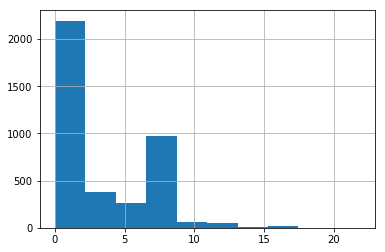

In [84]:
interest_changes_in_trades_range[interest_changes_in_trades_range.remaining.astype("float") > 0].remaining.astype("float").hist()

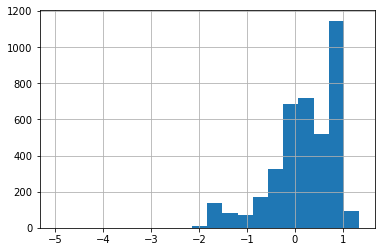

In [85]:
import numpy as np
interest_changes_in_trades_range[interest_changes_in_trades_range.remaining.astype("float") > 0].remaining.astype(
    "float").map(
    np.log10).hist(
    bins = 20)

Save interest change events

In [86]:
interest_changes_in_trades_range.to_json("gemini_interest.json", orient = "records")

Save trade events

In [156]:
all_updates_df[all_updates_df.reason == "trade"][["timestampms", "delta", "price"]].to_json("gemini_trades.json", orient = "records")